In [1]:
import numpy as np
from qutip import *
from math import sqrt
from scipy import *
import scipy.linalg
from qiskit import *
from numpy.linalg import eig
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import scipy.linalg
from qiskit.quantum_info import  Operator
from qiskit.opflow import I, X, Y, Z,H
import qiskit.quantum_info as qi


/var/folders/bm/9lz4gv9d21gf9g5dwnm7rgym0000gn/T/ipykernel_50847/3922184955.py:15: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import I, X, Y, Z,H


#  Multi processing

In [3]:
import ray
ray.init(num_cpus=32)

2024-05-01 13:54:38,451	INFO worker.py:1749 -- Started a local Ray instance.


Python version:,3.9.16
Ray version:,2.12.0


In [5]:
import os
import multiprocessing
print(os.cpu_count())
#print(len(os.sched_getaffinity(0)))
print(multiprocessing.cpu_count())

8
8


# Calculating OTOC

In [7]:
import timeit
from math import pi
N=40#number of samples
K=40# number of modules
starttime = timeit.default_timer()
correlation=20
M=9

def GaussianTheta(num_seq, sigma, num_instance):
    # output is a matrix of num_instance times num_seq, each row is one instance of Theta(sequence)
    """
    Generates a matrix of random values following a Gaussian random process.

    Args:
        num_seq (int): Number of Modules.
        sigma (float): Correlation lenght.
        num_instance (int): Number of instances.

    Returns:
        numpy.ndarray: Matrix of random values.
    """
    
    Delta = scipy.linalg.toeplitz( - np.arange(num_seq), np.arange(num_seq) )
    
    
    CovMat = np.exp( - np.power(Delta,2) / ( 2 * sigma ** 2 ) )
    
    
    eig_val, eig_vec = np.linalg.eigh(CovMat) 
    eig_val = np.maximum(eig_val, 0.0) 
    
    L = np.dot( np.sqrt(np.diag(eig_val)) , eig_vec.T )
    K = np.dot( np.random.randn( num_instance, num_seq ) , L )
    
    return K

ThetaX=np.ones((N,K,M))
for i in range(M):

    Seed=M+i
    np.random.seed(Seed)

    ThetaX[:,:,i] = GaussianTheta( K, correlation, N ) 


def module(circuit,theta):
    """
    Applies quantum gates to the quantum circuit.

    Args:
        ThetaX (numpy.ndarray):
        K (int): Number of modules.
        n (int): Index of the instance.
        circuit (QuantumCircuit): Quantum circuit to apply gates on.
        qr (QuantumRegister): Quantum register.
        M (int): Number of qubits.

    Returns:
        circuit
    """
        
    for j in range(1, M):
            
            circuit.rzz(theta=-pi/2, qubit1=qr[j-1], qubit2=qr[j])
    for j in range(M):
            circuit.rz(-pi/2,j)

    for j in range(M):
            circuit.rx(-2*theta[j],M-1-j)# apparently qiskit counts qubits inversly that is why I said M-1-j instead of j
    return(circuit)

def OTOC(circuit,operator_0):
    #print(circuit)
    return((np.array(qi.Operator(circuit)))@ np.array(qi.Operator(operator_0))
     @(np.conjugate(np.array(qi.Operator(circuit))).T))

def Norm(Op,Operator):
    return(commutator(Qobj(np.array(qi.Operator(Op[4])),dims = [[2]*M,[2]*M])
            ,Qobj(np.array(qi.Operator(Operator)),dims = [[2]*M,[2]*M]))).norm(norm='fro')




cr=ClassicalRegister(M)
qr=QuantumRegister(M)
Op=[]
for i in range(M):
    Op.append( ((I^i)^X^(I^(M-i-1))))


norm_store= []


@ray.remote
def Circuit_func(n,ii,circuit,operator_0,Op):
    #print('n',n)
    norm_store=[]
    for k in range(0,K):
        theta=ThetaX[n,k,:]
        #print('n,k',n,k)
        circuit=module(circuit,theta)
        #print(circuit)
        Operator = OTOC(circuit,operator_0)
        norm_store.append(Norm(Op,Operator))
        #print(Operator)
    return(norm_store)
result_list=[]
for n in range(N):
    for ii,op in enumerate(Op):
        operator_0=op
       
    
        circuit = QuantumCircuit(qr, cr)
        #print(norm_store)
        
        result_list.append(Circuit_func.remote(n,ii,circuit,operator_0,Op))
        
            #print(Op[0]) 
norm=np.reshape(ray.get(result_list),(N, len(Op),K))
norm_ave=np.average(norm,axis=0)            

print("The time difference is :", timeit.default_timer() - starttime)

KeyboardInterrupt: 

/tmp/ipykernel_5464/123682184.py:9: DeprecationWarning: scipy.real is deprecated and will be removed in SciPy 2.0.0, use numpy.real instead
  plt.imshow(real(norm_ave).T,aspect=6,origin='lower',cmap='jet',vmin=0,vmax=42)


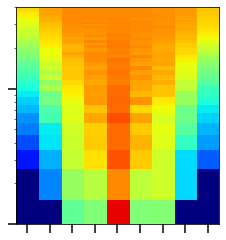

In [33]:

z=(np.stack([
scipy.interpolate.interp1d(np.linspace(0.0, 1.0, K),cd,kind='quadratic')(np.linspace(0.0, 1.0, 10*K))
for cd in norm_ave
]))
plt.imshow(real(norm_ave).T,aspect=6,origin='lower',cmap='jet',vmin=0,vmax=42)
#plt.colorbar()
plt.yscale('log')
plt.ylim([2,40])
#plt.axis('off')
plt.tick_params(width=1.5,labelbottom=False,axis='x')
plt.tick_params(width=1.5,labelleft=False,axis='y')
plt.xticks([0,1,2,3,4,5,6,7,8])
plt.yticks([1,10])
plt.savefig('OTOZ_zz_y_inhom.pdf',transparent=True, format='pdf',bbox_inches='tight')

In [2]:
Norm3=np.load('OTOZ_ZZ_z_inhom.npz')
Norm_3=Norm3['state']
Norm4=np.load('OTOZ_zz_x_inhom.npz')
Norm_4=Norm4['state']
Norm2=np.load('OTOZ_xx_x_inhom.npz')
Norm_2=Norm2['state']
Norm1=np.load('OTOZ_xx_z_inhom.npz')
Norm_1=Norm1['state']
Norm5=np.load('OTOZ_zz_y_inhom.npz')
Norm_5=Norm5['state']

/tmp/ipykernel_19026/973325090.py:9: DeprecationWarning: scipy.real is deprecated and will be removed in SciPy 2.0.0, use numpy.real instead
  plt.imshow(real(norm_ave).T,aspect=6,origin='lower',cmap='jet')


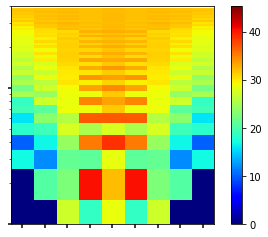

In [28]:
# inhomogenious
# zz model 'fro', average over 20 samples
#Open sigms_x(t)_j
#from matplotlib.colors import symlog()
z=(np.stack([
scipy.interpolate.interp1d(np.linspace(0.0, 1.0, K),cd,kind='quadratic')(np.linspace(0.0, 1.0, 10*K))
for cd in norm_ave
]))
plt.imshow(real(norm_ave).T,aspect=6,origin='lower',cmap='jet')
plt.colorbar()
plt.yscale('log')
plt.ylim([2,40])
#plt.axis('off')
plt.tick_params(width=1.5,labelbottom=False,axis='x')
plt.tick_params(width=1.5,labelleft=False,axis='y')
plt.xticks([0,1,2,3,4,5,6,7,8])
plt.yticks([1,10])
plt.savefig('OTOZ_zz_x_hom.pdf',transparent=True, format='pdf',bbox_inches='tight')

/tmp/ipykernel_2443/865015427.py:9: DeprecationWarning: scipy.real is deprecated and will be removed in SciPy 2.0.0, use numpy.real instead
  plt.imshow(real(norm_ave).T,aspect=6,origin='lower',cmap='jet')


([<matplotlib.axis.YTick at 0x1518ca548b20>,
 [])

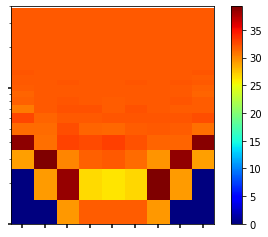

In [28]:
# inhomogenious
# zz model 'fro', average over 20 samples
#Open sigms_x(t)_j
#from matplotlib.colors import symlog()
z=(np.stack([
scipy.interpolate.interp1d(np.linspace(0.0, 1.0, K),cd,kind='quadratic')(np.linspace(0.0, 1.0, 10*K))
for cd in norm_ave
]))
plt.imshow(real(norm_ave).T,aspect=6,origin='lower',cmap='jet')
plt.colorbar()
plt.yscale('log')
plt.ylim([2,40])
#plt.axis('off')
plt.tick_params(width=1.5,labelbottom=False,axis='x')
plt.tick_params(width=1.5,labelleft=False,axis='y')
plt.xticks([0,1,2,3,4,5,6,7,8])
plt.yticks([1,10])
#plt.savefig('OTOZ_xx_x_inhom.pdf',transparent=True, format='pdf',bbox_inches='tight')

/tmp/ipykernel_5464/998281204.py:9: DeprecationWarning: scipy.real is deprecated and will be removed in SciPy 2.0.0, use numpy.real instead
  axes[0,0].imshow(real(Norm_3 ).T,aspect=6,origin='lower',cmap='jet',vmin=np.min(real(Norm_3 ).T), vmax=zz)
/tmp/ipykernel_5464/998281204.py:11: DeprecationWarning: scipy.real is deprecated and will be removed in SciPy 2.0.0, use numpy.real instead
  axes[0,1].imshow(real(Norm_1 ).T,aspect=6,origin='lower',cmap='jet',vmin=np.min(real(Norm_1 ).T), vmax=zz)
/tmp/ipykernel_5464/998281204.py:12: DeprecationWarning: scipy.real is deprecated and will be removed in SciPy 2.0.0, use numpy.real instead
  axes[1,0].imshow(real(Norm_4 ).T,aspect=6,origin='lower',cmap='jet',vmin=np.min(real(Norm_4 ).T), vmax=zz)
/tmp/ipykernel_5464/998281204.py:13: DeprecationWarning: scipy.real is deprecated and will be removed in SciPy 2.0.0, use numpy.real instead
  axes[1,1].imshow(real(Norm_2 ).T,aspect=6,origin='lower',cmap='jet',vmin=np.min(real(Norm_2 ).T), vmax=zz)


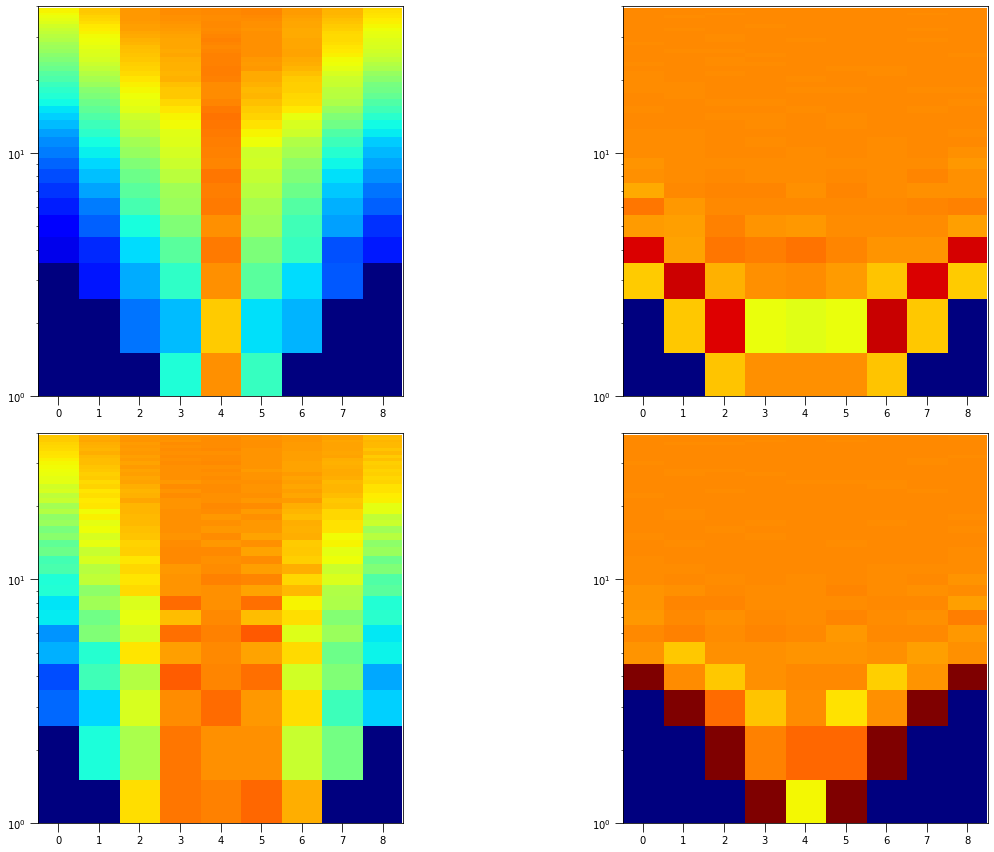

In [32]:
# 90000 samples
zz=42
fig, axes = plt.subplots(2, 2, figsize=(17,12))
fig.tight_layout()
#fig.suptitle(r'$fro,z$' ,size=35, y=1.05)
for j in range(3):
    for k in range(3*j,3*(j+1)):
        
        axes[0,0].imshow(real(Norm_3 ).T,aspect=6,origin='lower',cmap='jet',vmin=np.min(real(Norm_3 ).T), vmax=zz)
       # axes[0,0].colorbar()
        axes[0,1].imshow(real(Norm_1 ).T,aspect=6,origin='lower',cmap='jet',vmin=np.min(real(Norm_1 ).T), vmax=zz)
        axes[1,0].imshow(real(Norm_4 ).T,aspect=6,origin='lower',cmap='jet',vmin=np.min(real(Norm_4 ).T), vmax=zz)
        axes[1,1].imshow(real(Norm_2 ).T,aspect=6,origin='lower',cmap='jet',vmin=np.min(real(Norm_2 ).T), vmax=zz)
        
        
axes[0,0].set_yscale('log')
axes[0,1].set_yscale('log')
axes[1,0].set_yscale('log')
axes[1,1].set_yscale('log')
axes[0,0].set_ylim([1,40])
axes[0,1].set_ylim([1,40])
axes[1,1].set_ylim([1,40])
axes[1,0].set_ylim([1,40])
#legend.draggable()
plt.subplots_adjust(right=0.95)
#fig.colorbar()

/tmp/ipykernel_24695/293447561.py:9: DeprecationWarning: scipy.real is deprecated and will be removed in SciPy 2.0.0, use numpy.real instead
  plt.imshow(real(norm_ave).T,aspect=6,origin='lower',cmap='jet',vmin=0)


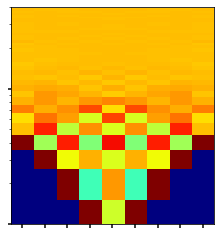

In [6]:
# inhomogenious
# zz model 'fro', average over 20 samples
#Open sigms_x(t)_j
#from matplotlib.colors import symlog()
z=(np.stack([
scipy.interpolate.interp1d(np.linspace(0.0, 1.0, K),cd,kind='quadratic')(np.linspace(0.0, 1.0, 10*K))
for cd in norm_ave
]))
plt.imshow(real(norm_ave).T,aspect=6,origin='lower',cmap='jet',vmin=0)
#plt.colorbar()
plt.yscale('log')
plt.ylim([2,40])
#plt.axis('off')
plt.tick_params(width=1.5,labelbottom=False,axis='x')
plt.tick_params(width=1.5,labelleft=False,axis='y')
plt.xticks([0,1,2,3,4,5,6,7,8])
plt.yticks([1,10])
plt.savefig('OTOZ_xx_x_hom.pdf',transparent=True, format='pdf',bbox_inches='tight')

/tmp/ipykernel_26532/2181461674.py:9: DeprecationWarning: scipy.real is deprecated and will be removed in SciPy 2.0.0, use numpy.real instead
  plt.imshow(real(Norm_2).T,aspect=6,origin='lower',cmap='jet',vmin=0, vmax=zz)


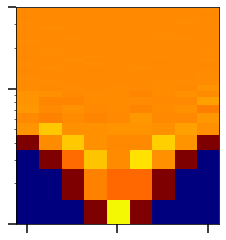

In [32]:
# inhomogenious
# zz model 'fro', average over 20 samples
#Open sigms_x(t)_j
#from matplotlib.colors import symlog()
z=(np.stack([
scipy.interpolate.interp1d(np.linspace(0.0, 1.0, K),cd,kind='quadratic')(np.linspace(0.0, 1.0, 10*K))
for cd in Norm_2
]))
plt.imshow(real(Norm_2).T,aspect=6,origin='lower',cmap='jet',vmin=0, vmax=zz)
#plt.colorbar()
plt.yscale('log')
plt.ylim([2,40])
#plt.axis('off')
plt.tick_params(width=1.5,labelbottom=False,axis='x')
plt.tick_params(width=1.5,labelleft=False,axis='y')
plt.xticks([0,4,8])
plt.yticks([1,10,40])
plt.savefig('OTOZ_xx_x_inhom.pdf',transparent=True, format='pdf',bbox_inches='tight')

/tmp/ipykernel_26532/731415293.py:9: DeprecationWarning: scipy.real is deprecated and will be removed in SciPy 2.0.0, use numpy.real instead
  plt.imshow(real(Norm_1).T,aspect=6,origin='lower',cmap='jet',vmin=0, vmax=zz)


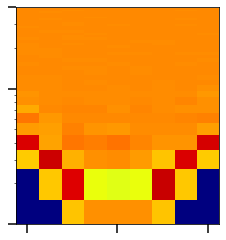

/tmp/ipykernel_26532/2407965952.py:11: DeprecationWarning: scipy.real is deprecated and will be removed in SciPy 2.0.0, use numpy.real instead
  plt.imshow(real(Norm_3).T,aspect=6,origin='lower',cmap='jet',vmin=0, vmax=zz)


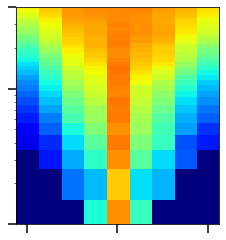

In [30]:
# inhomogenious
# zz model 'fro', average over 20 samples
#Open sigms_x(t)_j
#from matplotlib.colors import symlog()
zz=42
K=40
z=(np.stack([
scipy.interpolate.interp1d(np.linspace(0.0, 1.0, K),cd,kind='quadratic')(np.linspace(0.0, 1.0, 10*K))
for cd in Norm_3
]))
plt.imshow(real(Norm_3).T,aspect=6,origin='lower',cmap='jet',vmin=0, vmax=zz)
#plt.colorbar()
plt.yscale('log')
plt.ylim([2,40])
#plt.axis('off')
plt.tick_params(width=1.5,labelbottom=False,axis='x')
plt.tick_params(width=1.5,labelleft=False,axis='y')
plt.xticks([0,4,8])
plt.yticks([1,10,40])
plt.savefig('OTOZ_ZZ_z_inhom.pdf',transparent=True, format='pdf',bbox_inches='tight')

/tmp/ipykernel_26532/2110560619.py:10: DeprecationWarning: scipy.real is deprecated and will be removed in SciPy 2.0.0, use numpy.real instead
  plt.imshow(real(np.average(Norm_4,axis=0)).T,aspect=6,origin='lower',cmap='jet',vmin=0, vmax=zz)


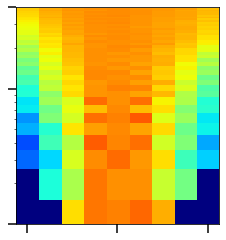

/tmp/ipykernel_26532/2547800324.py:9: DeprecationWarning: scipy.real is deprecated and will be removed in SciPy 2.0.0, use numpy.real instead
  plt.imshow(real(norm_ave).T,aspect=6,origin='lower',cmap='jet')


([<matplotlib.axis.YTick at 0x14970b8077f0>,
 [])

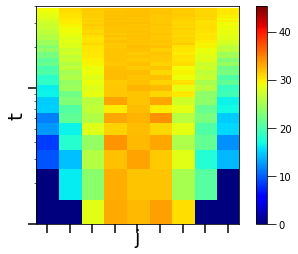

In [40]:
# inhomogenious
# zz model 'fro', average over 20 samples
#Open sigms_x(t)_j
#from matplotlib.colors import symlog()
z=(np.stack([
scipy.interpolate.interp1d(np.linspace(0.0, 1.0, K),cd,kind='quadratic')(np.linspace(0.0, 1.0, 10*K))
for cd in norm_ave
]))
plt.imshow(real(norm_ave).T,aspect=6,origin='lower',cmap='jet')
plt.colorbar()
plt.yscale('log')
plt.ylim([2,40])
plt.xlabel('j', size=20)
plt.ylabel('t',size=20)
plt.tick_params(width=1.5,labelbottom=False,axis='x')
plt.tick_params(width=1.5,labelleft=False,axis='y')
plt.xticks([0,1,2,3,4,5,6,7,8])
plt.yticks([1,10])
#fig.savefig('OTOZ_ZZ_z_inhom.pdf',transparent=True, format='pdf',bbox_inches='tight')

/tmp/ipykernel_26532/3072577746.py:9: DeprecationWarning: scipy.real is deprecated and will be removed in SciPy 2.0.0, use numpy.real instead
  plt.imshow(real(norm_ave).T,aspect=6,origin='lower',cmap='jet',vmin=0, vmax=zz)


([<matplotlib.axis.YTick at 0x14970b9b18b0>,
 [])

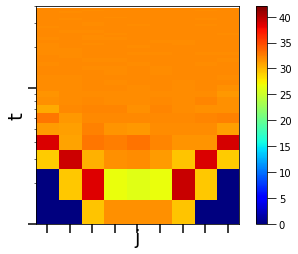

In [38]:
# inhomogenious
# zz model 'fro', average over 20 samples
#Open sigms_x(t)_j
#from matplotlib.colors import symlog()
z=(np.stack([
scipy.interpolate.interp1d(np.linspace(0.0, 1.0, K),cd,kind='quadratic')(np.linspace(0.0, 1.0, 10*K))
for cd in norm_ave
]))
plt.imshow(real(norm_ave).T,aspect=6,origin='lower',cmap='jet',vmin=0, vmax=zz)
plt.colorbar()
plt.yscale('log')
plt.ylim([2,40])
plt.xlabel('j', size=20)
plt.ylabel('t',size=20)
plt.tick_params(width=1.5,labelbottom=False,axis='x')
plt.tick_params(width=1.5,labelleft=False,axis='y')
plt.xticks([0,1,2,3,4,5,6,7,8])
plt.yticks([1,10])
#fig.savefig('OTOZ_ZZ_z_inhom.pdf',transparent=True, format='pdf',bbox_inches='tight')

/tmp/ipykernel_21736/2547800324.py:9: DeprecationWarning: scipy.real is deprecated and will be removed in SciPy 2.0.0, use numpy.real instead
  plt.imshow(real(norm_ave).T,aspect=6,origin='lower',cmap='jet')


([<matplotlib.axis.YTick at 0x14d87f755ac0>,
 [])

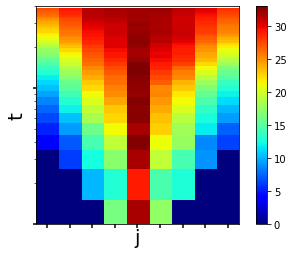

In [289]:
# inhomogenious
# zz model 'fro', average over 20 samples
#Open sigms_x(t)_j
#from matplotlib.colors import symlog()
z=(np.stack([
scipy.interpolate.interp1d(np.linspace(0.0, 1.0, K),cd,kind='quadratic')(np.linspace(0.0, 1.0, 10*K))
for cd in norm_ave
]))
plt.imshow(real(norm_ave).T,aspect=6,origin='lower',cmap='jet')
plt.colorbar()
plt.yscale('log')
plt.ylim([2,40])
plt.xlabel('j', size=20)
plt.ylabel('t',size=20)
plt.tick_params(width=1.5,labelbottom=False,axis='x')
plt.tick_params(width=1.5,labelleft=False,axis='y')
plt.xticks([0,1,2,3,4,5,6,7,8])
plt.yticks([1,10])
#fig.savefig('OTOZ_ZZ_z_inhom.pdf',transparent=True, format='pdf',bbox_inches='tight')

/tmp/ipykernel_21736/3406508584.py:9: DeprecationWarning: scipy.real is deprecated and will be removed in SciPy 2.0.0, use numpy.real instead
  plt.imshow(real(norm_ave).T,aspect=6,origin='lower',cmap='jet')


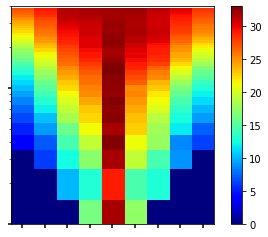

/tmp/ipykernel_26532/976405733.py:9: DeprecationWarning: scipy.real is deprecated and will be removed in SciPy 2.0.0, use numpy.real instead
  plt.imshow(real(norm_ave).T,aspect=6,origin='lower',cmap='jet',vmin=0, vmax=zz)


([<matplotlib.axis.YTick at 0x14970b9edb50>,
 [])

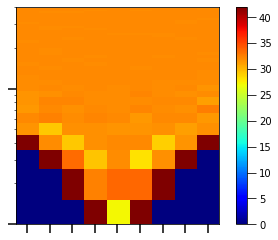

In [36]:
# inhomogenious
# zz model 'fro', average over 20 samples
#Open sigms_x(t)_j
#from matplotlib.colors import symlog()
z=(np.stack([
scipy.interpolate.interp1d(np.linspace(0.0, 1.0, K),cd,kind='quadratic')(np.linspace(0.0, 1.0, 10*K))
for cd in norm_ave
]))
plt.imshow(real(norm_ave).T,aspect=6,origin='lower',cmap='jet',vmin=0, vmax=zz)
plt.colorbar()
plt.yscale('log')
plt.ylim([2,40])
#plt.axis('off')
plt.tick_params(width=1.5,labelbottom=False,axis='x')
plt.tick_params(width=1.5,labelleft=False,axis='y')
plt.xticks([0,1,2,3,4,5,6,7,8])
plt.yticks([1,10])


In [41]:
np.savez('OTOZ_zz_x_inhom'+ ".npz", state=norm)

In [2]:
Norm3=np.load('OTOZ_ZZ_z_inhom.npz')
Norm_3=Norm3['state']
Norm4=np.load('OTOZ_zz_x_inhom.npz')
Norm_4=Norm4['state']
Norm2=np.load('OTOZ_xx_x_inhom.npz')
Norm_2=Norm2['state']
Norm1=np.load('OTOZ_xx_z_inhom.npz')
Norm_1=Norm1['state']

/tmp/ipykernel_21736/2261854919.py:9: DeprecationWarning: scipy.real is deprecated and will be removed in SciPy 2.0.0, use numpy.real instead
  plt.imshow(real(norm_ave).T,aspect=6,origin='lower',cmap='jet',vmin=0, vmax=32)


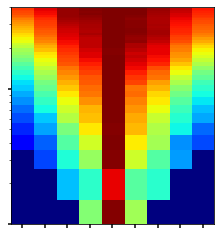

In [283]:
# inhomogenious
# zz model 'fro', average over 20 samples
#Open sigms_x(t)_j
#from matplotlib.colors import symlog()
z=(np.stack([
scipy.interpolate.interp1d(np.linspace(0.0, 1.0, K),cd,kind='quadratic')(np.linspace(0.0, 1.0, 10*K))
for cd in norm_ave
]))
plt.imshow(real(norm_ave).T,aspect=6,origin='lower',cmap='jet',vmin=0, vmax=32)
#plt.colorbar()
plt.yscale('log')
plt.ylim([2,40])
#plt.axis('off')
plt.tick_params(width=1.5,labelbottom=False,axis='x')
plt.tick_params(width=1.5,labelleft=False,axis='y')
plt.xticks([0,1,2,3,4,5,6,7,8])
plt.yticks([1,10])
fig.savefig('OTOZ_ZZ_z_inhom.pdf',transparent=True, format='pdf',bbox_inches='tight')

/tmp/ipykernel_5464/15305817.py:9: DeprecationWarning: scipy.real is deprecated and will be removed in SciPy 2.0.0, use numpy.real instead
  axes[k-3*j,j].imshow(real(norm[k]).T,aspect=6,origin='lower',cmap='jet')


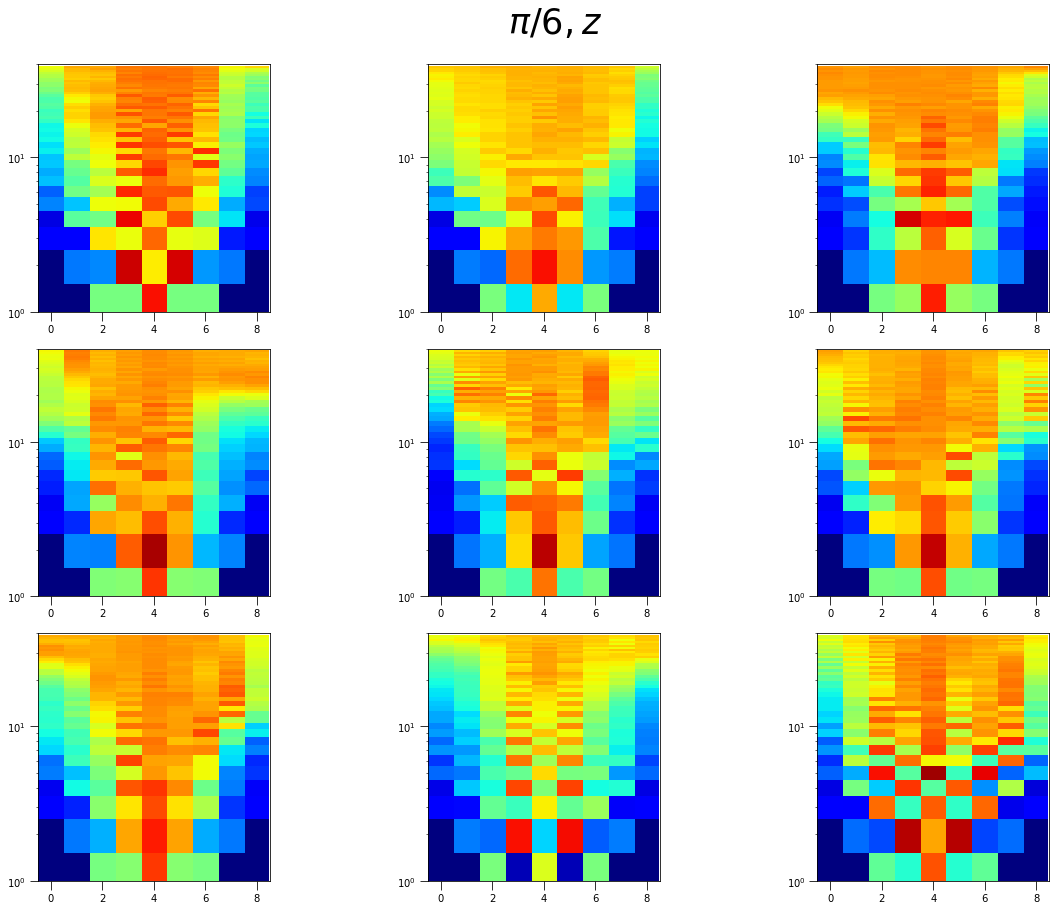

In [45]:
# 90000 samples

fig, axes = plt.subplots(3, 3, figsize=(17,12))
fig.tight_layout()
fig.suptitle(r'$\pi /6,z$' ,size=35, y=1.05)
for j in range(3):
    for k in range(3*j,3*(j+1)):
        
        axes[k-3*j,j].imshow(real(norm[k]).T,aspect=6,origin='lower',cmap='jet')
        axes[k-3*j,j].set_yscale('log')
        axes[k-3*j,j].set_ylim(1,40)
        

#legend.draggable()
plt.subplots_adjust(right=0.95)
#plt.colorbar()

/tmp/ipykernel_5464/652229182.py:9: DeprecationWarning: scipy.real is deprecated and will be removed in SciPy 2.0.0, use numpy.real instead
  plt.imshow(real(norm_ave).T,aspect=6,origin='lower',cmap='jet',vmin=0, vmax=32)


([<matplotlib.axis.YTick at 0x149b68c4cee0>,
 [])

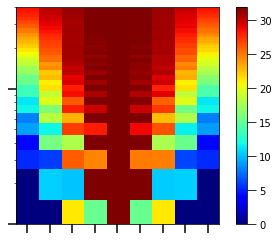

In [46]:
# inhomogenious
# zz model 'fro', average over 20 samples
#Open sigms_x(t)_j
#from matplotlib.colors import symlog()
z=(np.stack([
scipy.interpolate.interp1d(np.linspace(0.0, 1.0, K),cd,kind='quadratic')(np.linspace(0.0, 1.0, 10*K))
for cd in norm_ave
]))
plt.imshow(real(norm_ave).T,aspect=6,origin='lower',cmap='jet',vmin=0, vmax=32)
plt.colorbar()
plt.yscale('log')
plt.ylim([2,40])
#plt.axis('off')
plt.tick_params(width=1.5,labelbottom=False,axis='x')
plt.tick_params(width=1.5,labelleft=False,axis='y')
plt.xticks([0,1,2,3,4,5,6,7,8])
plt.yticks([1,10])
